In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(                         # transforms(): 이미지 파일로 저장된 것을 torch tensor로 읽고 변환해줌
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])   # 이미지 Tensor들을 Normalizing
# 이미지를 Tensor로 변환해주는 Function

#print(len(trainset))   # trainset 몇 개 들어 있는지 확인하기
# Define Data set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Load Data set
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=4, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
dataiter = iter(trainloader)                    # could return a stream of data reading from a database, a remote server, ore even logs generated in real time
images, labels = dataiter.next()

print(type(images), images.shape)               # <class 'torch.Tensor'> torch.Size([4, 3, 32, 32])--> torch.Size([batch size, RGB, w, h])
# print(type(labels), labels.shape, lables)
# torch에서 제공하지 않은 이미지말고 따로 다른 데이터셋을 불러 올 때는 shape, Resize를 확인해서 불러와봐야함
# shape를 확인안하고 파라미터를 잘못 입력해서 불러오면 pixel이 섞여서 이미지가 이상하게 불러와짐.

<class 'torch.Tensor'> torch.Size([4, 3, 32, 32])


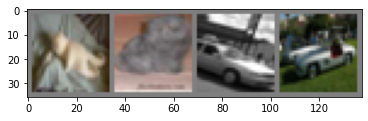

	  cat 	  cat 	  car 	  car
<class 'torch.Tensor'> torch.Size([4, 3, 32, 32])
<class 'torch.Tensor'> torch.Size([4]) tensor([3, 3, 1, 1])


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join('\t%5s' % classes[labels[j]] for j in range(4)))

print(type(images), images.shape) # numpy인지 Tensor인지 먼저 체크해줘야함
'''
torch.Size([4, 3, 32, 32]) --> [barch size, RGB channel, input x 가로, input x 세로]
32 x 32 x 3 = 3072 image x를 의미
'''

print(type(labels), labels.shape, labels)
# '''
# torch.Size([4]) 
# tensor([1, 6, 7, 9]) --> classes의 No.
# ==> 실제로 다른 곳에서 데이터셋을 가져로고 처리를 할때, reshape하는 과정에서 Dataset 마다 
# channel element가 다른 곳에 위치해 질 수 도 있음. CIFAR10에서는 (Data 수 * channel 수 * 32 * 32)의
# 순서지만 다른 Dataset에서는 저 순서가 아닐 수도 있다는 뜻. 이미지를 불럿을때 섞일수도 있음
# '''

In [12]:
import torch.nn as nn
import torch.nn.functional as F

# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(3, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(-1, 16 * 5 * 5)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

# net = Net()

class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, n_layer, act):
        super(MLP, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer
        self.act = act

        self.fc = nn.Linear(self.in_dim, self.hid_dim)
        self.linears = nn.ModuleList()

        for i in range(self.n_layer-1):
            self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))
        self.fc2 = nn.Linear(self.hid_dim, self.out_dim)

        if self.act == 'relu':
            self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.fc(x))        # 보통 act랑 fc는 같이 써서 한 Layer를 구분하여 사용함
        for fc in self.linears:
            x = self.act(fc(x))     # 마지막에는 ReLU를 하면 0이 될수 있으므로 마지막에 사용하면 안됨
        x = self.fc2(x)             # Activation Function을 지나지 않고 실수값을 뱉음

        return x

net = MLP(3072, 10, 100, 4, 'relu')     # (32*32*3, 10 classes, hid_dim, num of layers, activation function)
# print(model)                          # 정의된 모델의 쌓여진 레이어를 순서대로 볼 수 있음

In [13]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# print(criterion)
# print(optimizer)

In [15]:
# Training
for epoch in range(2):   # 데이터셋을 수차례 반복

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후,
        inputs, labels = data

        # 자신이 빌딩한 모델에 따라 reshape, 현재는 [sample 갯수, x의 전체 dim, ,]
        # Training 하면서 Dataset의 size를 reshape을 해주는 것이 정석 
        # print(inputs.shape)       # torch.Size([4, 3, 32, 32])
        inputs = inputs.view(-1, 3072)          # reshape
        # print(inputs.shape)       # torch.Size([4, 3072])

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후\
        outputs = net(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.221
[1,  4000] loss: 1.917
[1,  6000] loss: 1.792
[1,  8000] loss: 1.711
[1, 10000] loss: 1.668
[2,  2000] loss: 1.614
[2,  4000] loss: 1.590
[2,  6000] loss: 1.557
[2,  8000] loss: 1.552
[2, 10000] loss: 1.523
Finished Training


In [16]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [18]:
# net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [20]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

images = images.view(-1, 3072) 
outputs = net(images)

In [21]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  horse   cat  bird plane


In [23]:
# # Test set에 대한 Accuracy와 loss를 
# # Measure Test Accuracy
# correct = 0
# total = 0
# test_loss = 0
# with torch.no_grad():
#     for data in testloader:
#         images, labels = data
#         images = images.view(-1, 3072)      # added
#         outputs = net(images)
#         loss = criterion(outputs, labels)   # 각 배치에 대한 loss
#         test_loss += loss.item()            # iteration이 끝나면 나누어주기위해 각 배치에 대한 loss를 다 더함

#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
#         test_acc = 100 * correct / total

#     print(len(testloader))       # batch size를 확인하기위함,
#     test_loss = test_loss / len(testloader)
#     print('Test loss:\t', test_loss)

# print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

2500
Test loss:	 1.5541633893489837
Accuracy of the network on the 10000 test images: 43 %


In [24]:
# Validation set에 대한 Accuracy와 loss 구하기
# Measure Validation 
correct = 0
total = 0
val_loss = 0
with torch.no_grad():
    for data in valloader:
        images, labels = data
        images = images.view(-1, 3072)      # added
        outputs = net(images)

        loss = criterion(outputs, labels)
        val_loss += loss.item()               # 각 배치에서 나온 loss를 더함
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(len(valloader))   # 10000개의 validation set을 4개의 batch size에 나눠담겨져 있기때문에 한 덩이가 2500
    val_loss = val_loss / len(valloader)    
    print('Validation loss:\t', val_loss)

acc = 100 * correct / total
print('Validation Accuracy of the network on the 10000 test images: {:2.2f}%, Validation loss: {:2.3f}'.format(acc, val_loss))

# print('Accuracy of the network on the 10000 test images: %d %%' % (   # %d는 매우 구시대적 출력문...
#     100 * correct / total))

2500
Validation loss:	 1.563680054152012
Validation Accuracy of the network on the 10000 test images: 44.37%, Validation loss: 1.564


In [25]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.view(-1, 3072)
        outputs = net(images)

        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 49 %
Accuracy of   car : 34 %
Accuracy of  bird : 30 %
Accuracy of   cat : 18 %
Accuracy of  deer : 26 %
Accuracy of   dog : 54 %
Accuracy of  frog : 40 %
Accuracy of horse : 60 %
Accuracy of  ship : 59 %
Accuracy of truck : 64 %


In [26]:
# Experiment
def experiment(args):
    net = MLP(args.in_dim, args.out_dim, args.hid_dim, args.n_layer, args.act)
    # net.cuda()      # GPU 사용할 때
    # print(net)      # 생성된 Model 확인

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=args.lr, momentum=args.mm)

    # Training
    for epoch in range(args.epoch):   # 데이터셋을 수차례 반복합니다.   # Train과 Validation: Validation은 매 epoch마다 하는걸로
    # epoch 단위로 계산을 하고 있으므로 Train Loss를 Epoch 단위로 출력하는게 더 옳바름

        # Train
        running_loss = 0.0
        train_loss = 0.0        # Epoch 단위로 Train Loss 구하기
        for i, data in enumerate(trainloader, 0):
            # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
            inputs, labels = data
            # 자신이 빌딩한 모델에 따라 reshape, 현재는 MLP는 [sample 갯수, x의 전체 dim(3*32*32), ,]
            # Training 하면서 Dataset의 size를 reshape을 해주는 것이 정석 
            # print(inputs.shape)     # torch.Size([4, 3, 32, 32]) --> sample, x의
            inputs = inputs.view(-1, 3072)

            # inputs = inputs.cuda()        # GPU 사용할 때
            # labels = labels.cuda()        # GPU 사용할 때
            # print(inputs.shape)

            # 변화도(Gradient) 매개변수를 0으로 만들고
            optimizer.zero_grad()

            # 순전파 + 역전파 + 최적화를 한 후
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # 통계를 출력합니다.
            running_loss += loss.item()
            train_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

        # Validation
        correct = 0
        total = 0
        val_loss = 0
        with torch.no_grad():
            for data in valloader:
                images, labels = data
                images = images.view(-1, 3072)      # added

                # inputs = inputs.cuda()        # GPU 사용할 때
                # labels = labels.cuda()        # GPU 사용할 때

                outputs = net(images)

                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            print(len(valloader))   # 10000개의 validation set을 4개의 batch size에 나눠담겨져 있기때문에 한 덩이가 2500
            val_loss = val_loss / len(valloader)    
            # print('Validation loss:\t', val_loss)
            val_acc = 100 * correct / total

            print('Epoch {}, Train Loss {}: , Val Loss: {}, Val Acc: {}'.format(epoch, train_loss, val_loss, val_acc))

        # Evaluation(Test)
        correct = 0
        total = 0
        test_loss = 0
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                images = images.view(-1, 3072)      # added
                # images = images.cuda()  # For GPU
                # lables = labels.cuda()  # For GPU

                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            test_acc = 100 * correct / total
        
    return train_loss, val_loss, val_acc, test_acc

In [27]:
# Experiment
# Epoch이 끝나고 Loss를 출력할때 Train Loss라고 출력되는게 2000번마다 초기화한것을
import argparse
seed = 123                          # seed에 아무 어떤 정수를 입력하면 랜덤값을 항상 값은 값으로 저장해줌, 랜덤값 때문에 결과값이 바뀌는지 알 수 없으니 스타팅 포인트를 고정시키는 것
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")       # 터미널이 아니고 주피터노트북이기 때문에 ""를 넣어줘야함

args.n_layer = 5
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 100
args.act = 'relu'

args.lr = 0.001
args.mm = 0.9

args.epoch = 2

# list_val1 = [4, 5, 6]
# list_val2 = [50, 100, 150]

# for val1 in list_val1:      # for문을 돌려 자동으로 파라미터를 바꿔가면서 결과를 확인해보기
#     for val2 in list_val2:
#         args.n_layer = val1
#         args.hid_dim = val2
#         result = experiment(args)
#         print(result)

experiment(args)

[1,  2000] loss: 2.296
[1,  4000] loss: 2.098
[1,  6000] loss: 1.925
[1,  8000] loss: 1.794
[1, 10000] loss: 1.728
2500
Epoch 0, Train Loss 19684.287215948105: , Val Loss: 1.7152824720859527, Val Acc: 37.99
[2,  2000] loss: 1.670
[2,  4000] loss: 1.619
[2,  6000] loss: 1.604
[2,  8000] loss: 1.588
[2, 10000] loss: 1.575
2500
Epoch 1, Train Loss 16113.490042179823: , Val Loss: 1.5950721237003804, Val Acc: 42.08


(16113.490042179823, 1.5950721237003804, 42.08, 42.51)

In [ ]:
# Overfitting을 확인하려면 epoch 따라서 loss 그래프를 그려야함 --> 매 Epoch 마다 loss를 리스트에 저장해서 그 리스트로 그래프 그리기

# # seed test
# seed = 123      # 아무값이나 넣어도됨
# import random
# import numpy as np
# np.random.seed(seed)    # 랜덤으로 뽑은 값이 똑같이 고정됨, 시드로 파라미터를 고정시켜서 어떤 하이퍼라미터의 영향으로
#                         # 결과가 바꼇는지, 얼마나 영향이 가는지 정확히 파악하기 위함
# a = np.random.rand()
# print(a)